<a href="https://colab.research.google.com/github/ThrupthiAnn/CVSummerSchool2021/blob/main/RNN/3_ImageCaptioningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following is a pretrained CNN-RNN image captioning model from [Yunjey Choi](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning).


Try out some examples of your own and observe the results. 
Answer, the questions in the quiz, w.r.t the examples below.

### ARCHITECTURE

<img src="https://raw.githubusercontent.com/ThrupthiAnn/CVSummerSchool2021/main/RNN/data/model.png" alt="rnn" height=400px/>

In [4]:
# Download the pretrained model and vocab
!wget -nv -O 'pretrained_model.zip' https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
!wget -nv -O 'vocab.zip' https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
!unzip -q pretrained_model.zip
!unzip -q vocab.zip

2021-07-31 10:40:32 URL:https://uc1c78a0d08ac52945a5a845c9c0.dl.dropboxusercontent.com/cd/0/inline2/BTWKEv2JTBgD-BKtZbvGkIXWeUzqkhT6dyzZWBpiI5FNqh6PX4p2sq7iuj9vShEEJmd4Y0a2ryzOuxKb6XBV5n1NvnbQ7SzVgYjlnChVyqoOMdoZGhhRRNRS7acQKqEfL0xNhMkbrZLsKZ0jwR_eFFoZZRLl6l3OME4_S0_4diYAqkJJ8ay35fbX61cPaEGHwZo6JCwF5jjjyYtbaFoCjTJvG8p0qIuzBCaan2grhdcnWwsN0fk-3fYs5XuQBMkbjRH35ap2aJtlbEagMYItjuSRJSVOV9OWiOkoCvjS7YgcjNjfLtHFc6Bsz9_65sV6y1FpMNCjEXvgkFpwgLHOnqAM_GkGTTG474J0Hvlsf5pa-TCXfMbyZCoD-VQqbGY1iSE/file [253295231/253295231] -> "pretrained_model.zip" [1]
2021-07-31 10:40:33 URL:https://uc277d3232999b1b1f45d8251559.dl.dropboxusercontent.com/cd/0/inline2/BTVMe_6X9QHWLzT4KS4TV-TlYnaC3R9JME0K8cnEfK9wDGml0ZGmNtUZ8NtawmPNaIf0vtIOZjfZnJYS-Qhgpw8cKnKfuovDQCW5OnWenel9LIKzIWDbGallyM708pv-U-IlZjgryENm3aI0FnsdDYzp1hTQRd5ULuhBKGB7STzg2NDK7D5k6qHNr-dq3aB0dpfvQG9F2SOMS0HJdxn7rNC1M9lbh34vYQHVeAlVkNHyZSou1wn8IFacsj8D86oiEFfhpfjckRMU9WkKGLZfAA0iTJv_NJB40DaJyNAnpSAqL1fFYe4qFjkAYCOmRD9XVr3KoFArUgpYzM_dsoWYPMR8dEaZbfDyc6V

In [10]:
# Script/Code to build the vocab
!wget -nv -O build_vocab.py "https://raw.githubusercontent.com/ThrupthiAnn/CVSummerSchool2021/main/RNN/build_vocab.py"

2021-07-31 10:43:58 URL:https://raw.githubusercontent.com/ThrupthiAnn/CVSummerSchool2021/main/RNN/build_vocab.py [2555/2555] -> "build_vocab.py" [1]


In [43]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torch.autograd import Variable 
from torchvision import transforms 
from build_vocab import Vocabulary
from PIL import Image
%matplotlib inline

encoder_path='./encoder-5-3000.pkl'
decoder_path='./decoder-5-3000.pkl'
vocab_path='./vocab.pkl'
embed_size = 256
hidden_size = 512
num_layers = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-18 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
        
    def init_weights(self):
        """Initialize the weights."""
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, images):
        """Extract the image feature vectors."""
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights."""
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(20):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.linear(hiddens.squeeze(1))            # (batch_size, vocab_size)
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.cat(sampled_ids, 0)                  # (batch_size, 20)
        return sampled_ids.squeeze()

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image
    
def generate_caption(imgname):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build Models
    encoder = EncoderCNN(embed_size)
    encoder.eval()  # evaluation mode (BN uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, 
                         len(vocab), num_layers)
    
    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # Prepare Image
    image = load_image(imgname, transform)
    image_tensor = image.to(device)
    
    # use gpu
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # Generate caption from image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids.cpu().data.numpy()
    
    # Decode word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out image and generated caption.
    print (sentence)
    image = Image.open(imgname)
    plt.imshow(np.asarray(image))
    plt.show()

In [42]:
# Download sample images
!wget -nv https://raw.githubusercontent.com/ThrupthiAnn/CVSummerSchool2021/main/RNN/data/examples.zip
!unzip -q examples.zip

2021-07-31 11:13:37 URL:https://raw.githubusercontent.com/ThrupthiAnn/CVSummerSchool2021/main/RNN/data/examples.zip [657860/657860] -> "examples.zip" [1]


<start> a group of giraffes standing next to each other . <end>


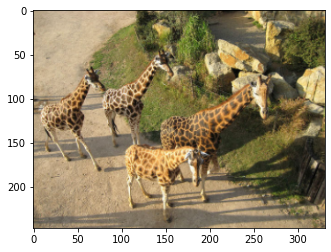

In [44]:
generate_caption('./ex1.png')

<start> a brown bear is standing in a field . <end>


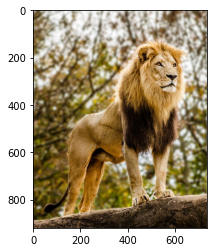

In [32]:
generate_caption('./ex2.png')

<start> a dog sitting on a couch with a cat on it . <end>


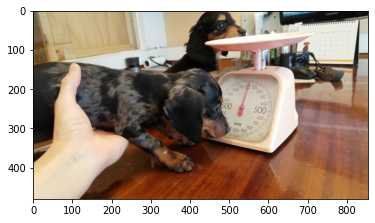

In [34]:
generate_caption('./ex3.png')

<start> a white and white cow standing in a field . <end>


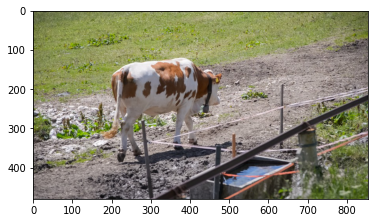

In [36]:
generate_caption('./ex4.png')